## How to use IndySDK
#### IndySDK 
Details are in IndyControlRNB/README

#### Web UI
* Joint control WebUI is on http://{Indy-IP}:9990/
* Task control WebUI is on http://{Indy-IP}:9991/ (If TaskControlRNB is used in indyDeploy.json)
* An instruction for Web UI is in [rnb-control/README.md](../README.md)


## You need urdf_parser_py to use kinematics functions
```bash
pip install urdf_parser_py.py
```

In [1]:
# ! pip install urdf_parser_py

### Run below cell

In [1]:
from utils.trajectory_client.indy_trajectory_client import IndyTrajectoryClient
traj_client = IndyTrajectoryClient(server_ip="192.168.21.6")

## Testing short motion

In [6]:
import numpy as np

In [7]:
Q1 = traj_client.get_qcur()
Q2 = np.add(Q1, np.pi/36)

In [12]:
traj_client.move_joint_s_curve(Q2, N_div=50)

Connect: Server IP (192.168.21.6)
Connect: Server IP (192.168.21.6)


In [9]:
traj_client.move_joint_s_curve(Q1, N_div=50)

Connect: Server IP (192.168.21.6)
Connect: Server IP (192.168.21.6)


## direct teaching

In [10]:
qlist=[]

#### Set the controller to gravity compensator and run below cell multiple times to save waypoints
* You don't have to press enabling button for direct teaching

In [13]:
qlist.append(traj_client.get_qcur())
print("q: {}".format(qlist[-1]))

q: [0.0869, 0.0873, -1.4844, 0.0883, -1.4838, 0.0823]


#### list all saved waypoints

In [14]:
for i_q, q in enumerate(qlist):
    print("q{}: {}".format(i_q, q))

q0: [-0.0004, -0.0002, -1.5712, 0.0015, -1.5706, -0.0021]
q1: [0.0869, 0.0873, -1.4844, 0.0883, -1.4838, 0.0823]


#### update target position and reset controller for safety

In [15]:
traj_client.move_joint_s_curve(traj_client.get_qcur(), N_div=50)
traj_client.reset()

Connect: Server IP (192.168.21.6)
Connect: Server IP (192.168.21.6)
Connect: Server IP (192.168.21.6)


{}

#### Set controller to NRIC_PD or other active one  - if the robot moves abruptly, restart the controller program

#### Run below cell to repeat the waypoint motion (move_joint_s_curve version)

In [16]:
for _ in range(3):
    for q in qlist:
        traj_client.move_joint_s_curve(q, N_div=50) # adjust speed by N_div

Connect: Server IP (192.168.21.6)
Connect: Server IP (192.168.21.6)
Connect: Server IP (192.168.21.6)
Connect: Server IP (192.168.21.6)
Connect: Server IP (192.168.21.6)
Connect: Server IP (192.168.21.6)
Connect: Server IP (192.168.21.6)
Connect: Server IP (192.168.21.6)
Connect: Server IP (192.168.21.6)
Connect: Server IP (192.168.21.6)
Connect: Server IP (192.168.21.6)
Connect: Server IP (192.168.21.6)


#### Run below cell to repeat the waypoint motion (move_joint_wp version)

In [17]:
for _ in range(3):
    traj_client.move_joint_wp(qlist, vel_lims=0.5, acc_lims=0.5, auto_stop=True) # adjust speed by vel_lims and acc_lims

Connect: Server IP (192.168.21.6)
Connect: Server IP (192.168.21.6)
Connect: Server IP (192.168.21.6)


## Task trajectory generation

### Prepare urdf content

In [18]:
from urdf_parser_py.urdf import URDF
from utils.joint_utils import *
from utils.traj_utils import *

urdf_content = URDF.from_xml_file("../urdf/indy7/indy7.urdf")
link_names = get_link_names(urdf_content)
joint_names = get_joint_names(urdf_content)
base_link, tip_link = link_names[0], link_names[-1]

Scalar element defined multiple times: collision
Unknown attribute: version


### Calculate task trajectory

In [19]:
from utils.algebra import *

In [21]:
## get current Q0, T0
Q0 = traj_client.get_qcur()
T0 = get_tf(tip_link, list2dict(Q0, joint_names), 
            urdf_content, from_link=base_link)

In [22]:
## make target
dT = SE3(Rot_axis(1,0), (0,0.1,0))
Ttar = np.matmul(T0, dT)

In [23]:
P0 = np.concatenate([T0[:3,3], list(reversed(Rot2zyx(T0[:3,:3])))])
P1 = np.concatenate([Ttar[:3,3], list(reversed(Rot2zyx(Ttar[:3,:3])))])

In [25]:
## Calculate s-curve trajectory in task space
se3_alg = Combined([Euclidean(3), RotationUVW()])


N_div = 100
dp = se3_alg.diff_in_alg(P0, [P1])

# make double-S curve in algebra
dp_traj = dp * (
    np.sin(np.pi * (np.arange(N_div,dtype=float)[:,np.newaxis] / N_div - 0.5)) + 1) / 2

### Calculate joint trajectory

In [27]:
dp_list = dp_traj[1:]-dp_traj[:-1]
Qi = np.copy(Q0)
joint_traj = []
for dp_i in dp_list:
    J = get_jacobian(
        tip_link, urdf_content, Qi, joint_names, ref_link=base_link)
    Qi += np.matmul(np.linalg.pinv(J), dp_i)
    joint_traj.append(np.copy(Qi))
Qfin = Qi

### check trajectory 

In [28]:
import matplotlib.pyplot as plt

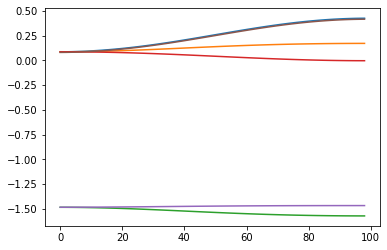

In [29]:
plt.plot(joint_traj)

### Move along joint trajectory

In [30]:
traj_client.move_joint_traj(joint_traj)

Connect: Server IP (192.168.21.6)


## Using gripper

In [ ]:
traj_client.grasp(True)

In [ ]:
traj_client.grasp(False)